# A data story.
## Pitchfork album reviews and Billboard top 100 album sales data for 1999 - 2016: what can we learn about music trends for that period?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Dinara\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Step 1. Read prevously scraped and cleaned Billboard data. The data shows albums on Billboard's weekly top 100 album sales chart, from the beginning of 1998 to March 10, 2018 when the data was scraped.

In [3]:
bb_df = pd.read_csv('billboard_albums_clnd.csv', parse_dates = ['date'])

In [6]:
bb_df.head()

,Unnamed: 0,artist,title,date,peakPos,weeks,rank
0,0,"""Weird Al"" Yankovic",Alpocalypse,2011-07-09,9,3,37.000000
1,1,"""Weird Al"" Yankovic",Mandatory Fun,2014-08-02,1,11,39.800000
2,2,"""Weird Al"" Yankovic",Poodle Hat,2003-06-07,17,9,56.555556
3,3,"""Weird Al"" Yankovic",Running With Scissors,1999-07-17,35,14,44.428571
4,4,"""Weird Al"" Yankovic","Squeeze Box: The Complete Works Of ""Weird Al"" ...",2017-12-16,65,1,65.000000


Each row represents an album, the week when it first appeared on the chart ('date' column), its peak position, number of weeks it spent on the chart, and its average rank in the chart.

In [7]:
bb_df = bb_df.rename(columns={'date': 'first_week'})
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13407 entries, 0 to 13406
Data columns (total 7 columns):
Unnamed: 0    13407 non-null int64
artist        13407 non-null object
title         13407 non-null object
first_week    13407 non-null datetime64[ns]
peakPos       13407 non-null int64
weeks         13407 non-null int64
rank          13407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 733.3+ KB


In [8]:
bb_df.drop('Unnamed: 0', axis = 1, inplace = True)

### Step 2. Read in and fill null values in previously cleaned Pitchfork reviews data.

In [10]:
pf_df = pd.read_csv('pitchfork_data_cleaned_2018-03-29.csv', parse_dates = ['pub_date'], encoding="ISO-8859-1")
pf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18379 entries, 0 to 18378
Data columns (total 18 columns):
Unnamed: 0        18379 non-null int64
reviewid_main     18379 non-null int64
content           18379 non-null object
genre             16015 non-null object
label             18332 non-null object
title             18377 non-null object
artist            18377 non-null object
url               18379 non-null object
score             18379 non-null float64
best_new_music    18379 non-null int64
author            18379 non-null object
author_type       14478 non-null object
pub_date          18379 non-null datetime64[ns]
pub_weekday       18379 non-null int64
pub_day           18379 non-null int64
pub_month         18379 non-null int64
pub_year          18379 non-null int64
year              17973 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(7), object(8)
memory usage: 2.5+ MB


The encoding does not work well with the special characters in the names of these artists and albums, so I filled them in with acceptable symbols.

In [11]:
pf_df[pf_df.title.isnull() | pf_df.artist.isnull()]

,Unnamed: 0,reviewid_main,content,genre,label,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year
6874,6877,10321,Everyone should be wary of pulling out the fol...,electronic,because,NaN,justice,http://pitchfork.com/reviews/albums/10321-just...,8.4,1,jess harvell,contributor,2007-06-12,1,12,6,2007,2007.0
14963,14970,18989,Do you have a meaningful relationship with the...,NaN,sumerian,NaN,NaN,http://pitchfork.com/reviews/albums/18989-cros...,5.0,0,ian cohen,contributor,2014-02-12,2,12,2,2014,2014.0
15001,15009,19032,The Finnish musician Mika Vainio appears to ha...,NaN,sahko,konstellaatio,NaN,http://pitchfork.com/reviews/albums/19032-arti...,7.4,0,grayson haver currin,contributor,2014-02-27,3,27,2,2014,2014.0


In [12]:
pf_df.ix[15001,'artist'] = 'scandinavian o'
pf_df.ix[6874,'title'] = 'cross'
pf_df.ix[14963, 'artist'], pf_df.ix[14963, 'title'] = 'crosses', 'crosses'
pf_df[pf_df.title.isnull() | pf_df.artist.isnull()]

,Unnamed: 0,reviewid_main,content,genre,label,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year


### Step 3. Let's try to merge the two dataframes. 

Trying to straight up cross join these two dataframes, pf_df and bb_df, caused a memory error on my machine, so we are going to have to come up with a different strategy. 

Instead, let's pre-process them, so that the fields we merge on look the same, and also make sure we do not include in the merge the albums that are definitely not in both of them.

In [13]:
bb_df[bb_df['title'].str.startswith(' ') | bb_df['title'].str.endswith(' ')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
artist        0 non-null object
title         0 non-null object
first_week    0 non-null datetime64[ns]
peakPos       0 non-null int64
weeks         0 non-null int64
rank          0 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 0.0+ bytes


In [14]:
pf_df[pf_df['title'].str.startswith(' ') | pf_df['title'].str.endswith(' ')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 781 to 18251
Data columns (total 18 columns):
Unnamed: 0        81 non-null int64
reviewid_main     81 non-null int64
content           81 non-null object
genre             76 non-null object
label             81 non-null object
title             81 non-null object
artist            81 non-null object
url               81 non-null object
score             81 non-null float64
best_new_music    81 non-null int64
author            81 non-null object
author_type       73 non-null object
pub_date          81 non-null datetime64[ns]
pub_weekday       81 non-null int64
pub_day           81 non-null int64
pub_month         81 non-null int64
pub_year          81 non-null int64
year              81 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(7), object(8)
memory usage: 12.0+ KB


In [15]:
pf_df['title'] = pf_df['title'].map(lambda x: x.strip())
pf_df[pf_df['title'].str.startswith(' ') | pf_df['title'].str.endswith(' ')]

,Unnamed: 0,reviewid_main,content,genre,label,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year


In [16]:
bb_df['artist'] = bb_df['artist'].str.lower()
bb_df['title'] = bb_df['title'].str.lower()
bb_df.head()

,artist,title,first_week,peakPos,weeks,rank
0,"""weird al"" yankovic",alpocalypse,2011-07-09,9,3,37.000000
1,"""weird al"" yankovic",mandatory fun,2014-08-02,1,11,39.800000
2,"""weird al"" yankovic",poodle hat,2003-06-07,17,9,56.555556
3,"""weird al"" yankovic",running with scissors,1999-07-17,35,14,44.428571
4,"""weird al"" yankovic","squeeze box: the complete works of ""weird al"" ...",2017-12-16,65,1,65.000000


Let's remove all punctuation in the titles, so that the same album names are represented by the same exact strings, so we do not differentiate between *'acoustic recordings 1996-2016'* and *'acoustic recordings: 1996-2016'*.

In [23]:
pf_df['title_nopunc'] = pf_df['title'].str.replace('[^\w\s]','')
bb_df['title_nopunc'] = bb_df['title'].str.replace('[^\w\s]','')

In [24]:
pf_df['title_nopunc'] = pf_df['title_nopunc'].map(lambda x: x.strip())
bb_df['title_nopunc'] = bb_df['title_nopunc'].map(lambda x: x.strip())

Let's start combining Pitchfork and Billboard data, keeping in mind that two completely different albums may share the same name, e.g. 'Greatest Hits', so in addition to matching album names, we will need to match artists names to arrive at a correct inner merge. 

We will match artist names like this, to account for collaborations: the name of the artist on Pitchfork should be contained within the name of the artist on Billboard. <br> We trust that Billboard will have all artist names included, more so than Pitchfork, because Pitchfork data came with a separate Artists table that may have contained more artists per review than their main Reviews table.

In [27]:
def match_artists(x):
    return (x['artist_pf'] in x['artist_bb'])

Let's merge based on titles without punctuation, then filter on artists

In [28]:
df_title_nopunc = pd.merge(pf_df, bb_df, on=['title_nopunc'], suffixes=('_pf', '_bb'))
df_title_nopunc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3518 entries, 0 to 3517
Data columns (total 25 columns):
Unnamed: 0        3518 non-null int64
reviewid_main     3518 non-null int64
content           3518 non-null object
genre             3372 non-null object
label             3500 non-null object
title_pf          3518 non-null object
artist_pf         3518 non-null object
url               3518 non-null object
score             3518 non-null float64
best_new_music    3518 non-null int64
author            3518 non-null object
author_type       2865 non-null object
pub_date          3518 non-null datetime64[ns]
pub_weekday       3518 non-null int64
pub_day           3518 non-null int64
pub_month         3518 non-null int64
pub_year          3518 non-null int64
year              3477 non-null float64
title_nopunc      3518 non-null object
artist_bb         3518 non-null object
title_bb          3518 non-null object
first_week        3518 non-null datetime64[ns]
peakPos           3518 n

In [29]:
df_title_nopunc['artist_match'] = df_title_nopunc.apply(match_artists, axis = 1)
df_title_nopunc['artist_match'].value_counts()

False    1782
True     1736
Name: artist_match, dtype: int64

In [30]:
df_title_nopunc_then_artist = df_title_nopunc[df_title_nopunc['artist_match']]

How about removing punctuation from artists too?

In [31]:
def match_artists_nopunc(x):
    return (x['artist_pf'].replace('[^\w\s]','') in x['artist_bb'].replace('[^\w\s]',''))

In [32]:
df_title_nopunc['artist_match_no_punc'] = df_title_nopunc.apply(match_artists_nopunc, axis = 1)
df_title_nopunc['artist_match_no_punc'].value_counts()

False    1782
True     1736
Name: artist_match_no_punc, dtype: int64

The result is the same as for keeping punctuation in artists' names, so `df_title_nopunc_then_artist` is good to go as our inner merge result.

Let's remove some of the variables we have accumulated that are duplicative or will not serve us much in our visualizations.

In [33]:
df_title_nopunc_then_artist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1736 entries, 1 to 3517
Data columns (total 26 columns):
Unnamed: 0        1736 non-null int64
reviewid_main     1736 non-null int64
content           1736 non-null object
genre             1699 non-null object
label             1734 non-null object
title_pf          1736 non-null object
artist_pf         1736 non-null object
url               1736 non-null object
score             1736 non-null float64
best_new_music    1736 non-null int64
author            1736 non-null object
author_type       1514 non-null object
pub_date          1736 non-null datetime64[ns]
pub_weekday       1736 non-null int64
pub_day           1736 non-null int64
pub_month         1736 non-null int64
pub_year          1736 non-null int64
year              1727 non-null float64
title_nopunc      1736 non-null object
artist_bb         1736 non-null object
title_bb          1736 non-null object
first_week        1736 non-null datetime64[ns]
peakPos           1736 n

In [34]:
df = df_title_nopunc_then_artist
df.drop(['Unnamed: 0', 'artist_match'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1736 entries, 1 to 3517
Data columns (total 24 columns):
reviewid_main     1736 non-null int64
content           1736 non-null object
genre             1699 non-null object
label             1734 non-null object
title_pf          1736 non-null object
artist_pf         1736 non-null object
url               1736 non-null object
score             1736 non-null float64
best_new_music    1736 non-null int64
author            1736 non-null object
author_type       1514 non-null object
pub_date          1736 non-null datetime64[ns]
pub_weekday       1736 non-null int64
pub_day           1736 non-null int64
pub_month         1736 non-null int64
pub_year          1736 non-null int64
year              1727 non-null float64
title_nopunc      1736 non-null object
artist_bb         1736 non-null object
title_bb          1736 non-null object
first_week        1736 non-null datetime64[ns]
peakPos           1736 non-null int64
weeks             1736 n

C:\Users\Dinara\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


And remove any duplicates.

In [40]:
df[df.duplicated(subset=['reviewid_main'])]

,reviewid_main,content,genre,label,title_pf,artist_pf,url,score,best_new_music,author,...,pub_month,pub_year,year,title_nopunc,artist_bb,title_bb,first_week,peakPos,weeks,rank
2033,13316,"Heartbreak is a constant in popular music, an...",pop/r&b,columbia,blacksummers'night,maxwell,http://pitchfork.com/reviews/albums/13316-blac...,7.8,0,david drake,...,7,2009,2009.0,blacksummersnight,maxwell,blacksummers'night,2016-07-23,2,14,43.642857
2035,22057,"Though consistently excellent, Maxwell has alw...",pop/r&b,columbia,blacksummersnight,maxwell,http://pitchfork.com/reviews/albums/22057-maxw...,8.4,1,rebecca haithcoat,...,7,2016,2016.0,blacksummersnight,maxwell,blacksummers'night,2016-07-23,2,14,43.642857


In [41]:
df[df['title_nopunc'] == 'blacksummersnight']

,reviewid_main,content,genre,label,title_pf,artist_pf,url,score,best_new_music,author,...,pub_month,pub_year,year,title_nopunc,artist_bb,title_bb,first_week,peakPos,weeks,rank
2032,13316,"Heartbreak is a constant in popular music, an...",pop/r&b,columbia,blacksummers'night,maxwell,http://pitchfork.com/reviews/albums/13316-blac...,7.8,0,david drake,...,7,2009,2009.0,blacksummersnight,maxwell,blacksummers'night,2009-07-25,1,36,44.733333
2033,13316,"Heartbreak is a constant in popular music, an...",pop/r&b,columbia,blacksummers'night,maxwell,http://pitchfork.com/reviews/albums/13316-blac...,7.8,0,david drake,...,7,2009,2009.0,blacksummersnight,maxwell,blacksummers'night,2016-07-23,2,14,43.642857
2034,22057,"Though consistently excellent, Maxwell has alw...",pop/r&b,columbia,blacksummersnight,maxwell,http://pitchfork.com/reviews/albums/22057-maxw...,8.4,1,rebecca haithcoat,...,7,2016,2016.0,blacksummersnight,maxwell,blacksummers'night,2009-07-25,1,36,44.733333
2035,22057,"Though consistently excellent, Maxwell has alw...",pop/r&b,columbia,blacksummersnight,maxwell,http://pitchfork.com/reviews/albums/22057-maxw...,8.4,1,rebecca haithcoat,...,7,2016,2016.0,blacksummersnight,maxwell,blacksummers'night,2016-07-23,2,14,43.642857


In [42]:
df.drop_duplicates(subset = ['reviewid_main'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 1 to 3517
Data columns (total 24 columns):
reviewid_main     1734 non-null int64
content           1734 non-null object
genre             1697 non-null object
label             1732 non-null object
title_pf          1734 non-null object
artist_pf         1734 non-null object
url               1734 non-null object
score             1734 non-null float64
best_new_music    1734 non-null int64
author            1734 non-null object
author_type       1512 non-null object
pub_date          1734 non-null datetime64[ns]
pub_weekday       1734 non-null int64
pub_day           1734 non-null int64
pub_month         1734 non-null int64
pub_year          1734 non-null int64
year              1725 non-null float64
title_nopunc      1734 non-null object
artist_bb         1734 non-null object
title_bb          1734 non-null object
first_week        1734 non-null datetime64[ns]
peakPos           1734 non-null int64
weeks             1734 n

C:\Users\Dinara\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [43]:
print('Only about %.2f percent of albums reviewed by Pitchfork ever appear on Billboard 100 Top Album Chart.' %(len(df)*100/len(pf_df)))

Only about 9.43 percent of albums reviewed by Pitchfork ever appear on Billboard 100 Top Album Chart.


# Insight 1: Only about 9.4% of albums reviewed by Pitchfork ever appear on Billboard 100 Top Album Sales Chart. Pitchfork definitely lives up to its indie image!

### Step 4. For albums appearing in both, what is the difference between review publication and Billboard first week appearance?

In [44]:
from datetime import datetime
from datetime import timedelta

In [45]:
delta = pd.to_datetime(df['first_week']).subtract(pd.to_datetime(df['pub_date'])) 

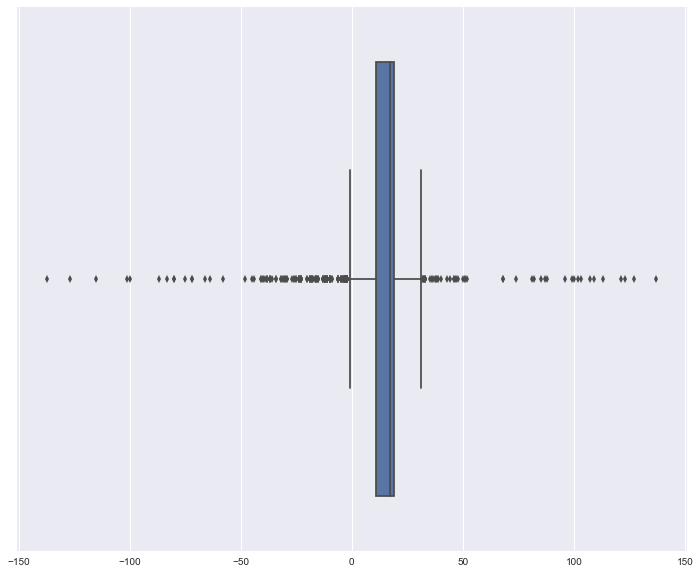

In [46]:
%matplotlib inline
from matplotlib.pylab import rcParams
import math
rcParams['figure.figsize'] = 12, 10
days = delta.apply(lambda x: x.days)
days_no_outliers = [x for x in days if abs(x)<140]
sns.boxplot(days_no_outliers)

In [47]:
days.describe()

count    1734.000000
mean       -2.862168
std       526.211558
min     -6853.000000
25%        11.000000
50%        17.000000
75%        19.000000
max      5744.000000
dtype: float64

# Insight 2: Over 50% of these albums first appear on Billboard within 2-3 weeks after the Pitchfork review.

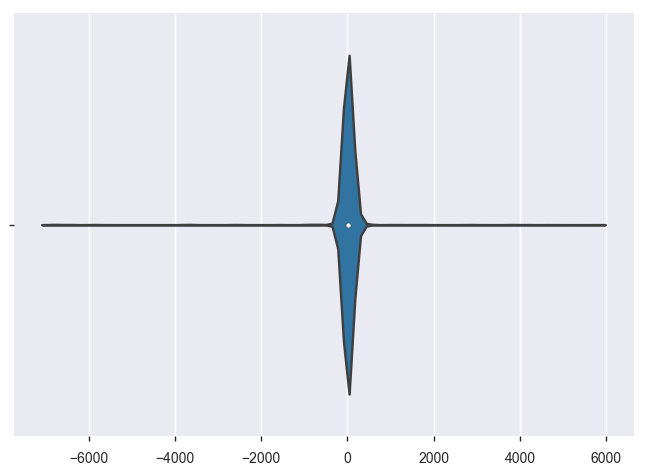

In [51]:
sns.violinplot(days)

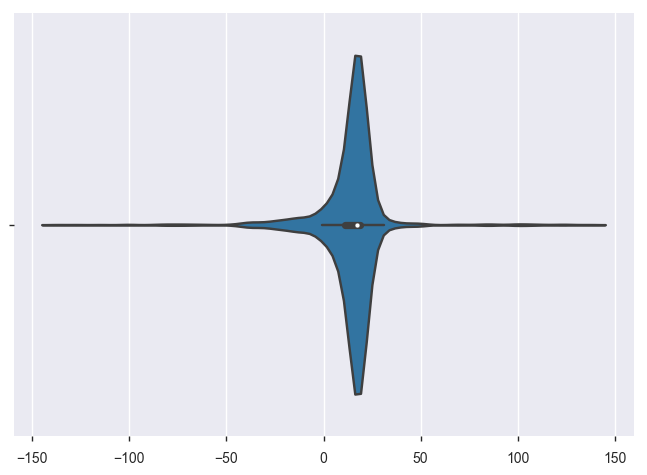

In [52]:
sns.violinplot(days_no_outliers)

In [53]:
year_diff = df[abs(days)>365]
year_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 2 to 3513
Data columns (total 24 columns):
reviewid_main     37 non-null int64
content           37 non-null object
genre             37 non-null object
label             37 non-null object
title_pf          37 non-null object
artist_pf         37 non-null object
url               37 non-null object
score             37 non-null float64
best_new_music    37 non-null int64
author            37 non-null object
author_type       29 non-null object
pub_date          37 non-null datetime64[ns]
pub_weekday       37 non-null int64
pub_day           37 non-null int64
pub_month         37 non-null int64
pub_year          37 non-null int64
year              36 non-null float64
title_nopunc      37 non-null object
artist_bb         37 non-null object
title_bb          37 non-null object
first_week        37 non-null datetime64[ns]
peakPos           37 non-null int64
weeks             37 non-null int64
rank              37 non-null floa

In [54]:
len(year_diff)/len(days)*100

2.1337946943483272

# Insight 3: About 2% of albums that are both reviewed by Pitchfork, and are on Billboard, are such that their review on Pitchfork and Billboard appearance are *over a year apart*.

In [56]:
pf_then_bb = df[days>365]
len(pf_then_bb)/len(year_diff)*100

45.94594594594595

# And over half of those outliers are such that Pitchfork is playing catch-up with Billboard, reviewing albums that became commercially successful over a year later!

### Step 5. Now let's explore how Pitchfork treats some of the most successful albums on Billboard.

In [59]:
df.loc[df['weeks'].idxmax()]

reviewid_main                                                  2773
content           Frankly, I don't want to hear these songs anym...
genre                                                           rap
label                                                    interscope
title_pf                                     curtain call: the hits
artist_pf                                                    eminem
url               http://pitchfork.com/reviews/albums/2773-curta...
score                                                           6.9
best_new_music                                                    0
author                                               sean fennessey
author_type                                             contributor
pub_date                                        2005-12-05 00:00:00
pub_weekday                                                       0
pub_day                                                           5
pub_month                                       

# Insight 4: Among the albums that Pitchfork reviewed the one that spent the most number of weeks on Billboard albums chart: Eminem's 'Curtain Call: the Hits'. Pitchfork reviewed it a couple of weeks before it debuted on Billboard, and the review is less than complimentary.
Notably, Pitchfork's mean review score is about 7.0, and they consider albums with scores 8+ excellent (according to their website).

count    18379.000000
mean         7.006110
std          1.292819
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: score, dtype: float64

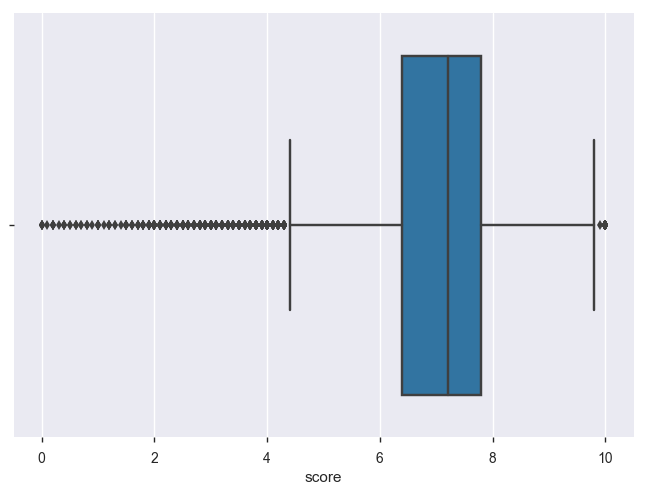

In [62]:
#Footnote. Overall Pitchfork score statistics:
sns.boxplot(pf_df.score)
pf_df.score.describe()

What about the rest of the commercially successful albums on that list? Let's assume an album is definitely a commercial success if it was on Billboard album chart for over 52 weeks.

In [64]:
over_52weeks = df[df['weeks']>=52]
over_52weeks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 39 to 3499
Data columns (total 24 columns):
reviewid_main     77 non-null int64
content           77 non-null object
genre             77 non-null object
label             77 non-null object
title_pf          77 non-null object
artist_pf         77 non-null object
url               77 non-null object
score             77 non-null float64
best_new_music    77 non-null int64
author            77 non-null object
author_type       67 non-null object
pub_date          77 non-null datetime64[ns]
pub_weekday       77 non-null int64
pub_day           77 non-null int64
pub_month         77 non-null int64
pub_year          77 non-null int64
year              77 non-null float64
title_nopunc      77 non-null object
artist_bb         77 non-null object
title_bb          77 non-null object
first_week        77 non-null datetime64[ns]
peakPos           77 non-null int64
weeks             77 non-null int64
rank              77 non-null flo

count    77.000000
mean      6.727273
std       1.887398
min       1.500000
25%       5.500000
50%       6.900000
75%       8.200000
max      10.000000
Name: score, dtype: float64

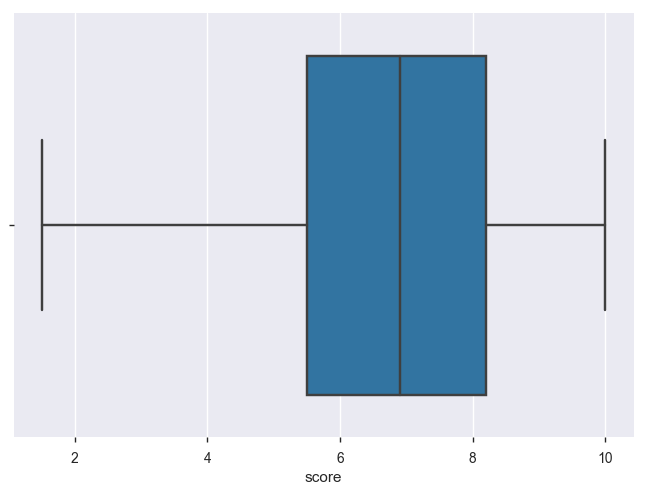

In [66]:
sns.boxplot(over_52weeks.score)
over_52weeks.score.describe()

# Insight 5: Pitchfork does not have a uniform idea about the most successful Billboard albums. It does not review a lot of albums that are on Billboard, but for the ones it does, the mean and median scores are slightly lower than for its entire body of reviews, and standard deviation is higher. 

In [67]:
from scipy import stats
t, p = stats.ttest_ind(pf_df.score, over_52weeks.score)
print('t-statistic is %.4f' %t)
print('p value is %.4f' %p)

t-statistic is 1.8843
p value is 0.0595


# There's a slight tendency for Pitchfork to treat commercially successful albums differently than the rest of the albums they review.

### Step 6. What music do Pitchfork and Billboard (i.e. the public voting with their wallets) agree was the best between 1999 and 2016 inclusive?

In [90]:
pf_bb_dreamteam = df[(df.weeks >=52) & (df.score >=8) & (df.year >= 1999)]
pf_bb_dreamteam.head()

,reviewid_main,content,genre,label,title_pf,artist_pf,url,score,best_new_music,author,...,pub_month,pub_year,year,title_nopunc,artist_bb,title_bb,first_week,peakPos,weeks,rank
381,2771,ryan loves it and he likes mmlp too so he's al...,rap,interscope,the eminem show,eminem,http://pitchfork.com/reviews/albums/2771-the-e...,9.1,0,ethan p.,...,6,2002,2002.0,the eminem show,eminem,the eminem show,2002-06-08,1,223,52.960000
412,9669,"John Lennon's ""Glass Onion"", a daffy throwaway...",rock,capitol,love,the beatles,http://pitchfork.com/reviews/albums/9669-love/,8.5,0,mark richardson,...,11,2006,2006.0,love,the beatles,love,2006-12-09,4,84,54.090909
965,4351,Eight thousand Michael Jackson fans-- the ones...,pop/r&b,sony,the essential michael jackson,michael jackson,http://pitchfork.com/reviews/albums/4351-the-e...,8.7,0,david raposa,...,8,2005,2005.0,the essential michael jackson,michael jackson,the essential michael jackson,2005-08-13,96,126,77.470588
1153,15585,One of the year's best music videos was direct...,pop/r&b,columbia,4,beyonc,http://pitchfork.com/reviews/albums/15585-4/,8.0,0,ryan dombal,...,6,2011,2011.0,4,beyonce,4,2011-07-16,1,61,43.100000
1192,14890,"For reasons I won't get into here, my little b...",rock,universal,pretty hate machine,nine inch nails,http://pitchfork.com/reviews/albums/14890-pret...,9.5,1,tom breihan,...,11,2010,2010.0,pretty hate machine,nine inch nails,pretty hate machine,2010-12-11,75,75,78.000000


In [92]:
pf_bb_dreamteam.artist_bb.value_counts()

drake                3
beyonce              2
kendrick lamar       2
the beatles          1
michael jackson      1
justin timberlake    1
lil wayne            1
kanye west           1
eminem               1
the strokes          1
phoenix              1
arctic monkeys       1
nine inch nails      1
Name: artist_bb, dtype: int64

In [93]:
pf_bb_dreamteam.genre.value_counts()

rap        8
rock       5
pop/r&b    4
Name: genre, dtype: int64

In [94]:
pf_bb_dreamteam.year.value_counts()

2013.0    3
2010.0    2
2011.0    2
2015.0    1
2012.0    1
2009.0    1
2016.0    1
2008.0    1
2004.0    1
2001.0    1
2005.0    1
2006.0    1
2002.0    1
Name: year, dtype: int64

#  Insight 6: All hail Drake, Beyonce, and Kendrick Lamar: they pleased both the general public and the more indie Pitchfork between 1999 and 2016! <br> 

# Insight 7:  Rap as the most crowdpleasing genre for both general public and indie folks is a surprise for me personally, as rock is what I always perceived it to be. <br> 

# Insight 8: 2010, 2011, and 2013 were the years allround well-received music was coming out the most (again, if we only consider the data available to us: 1999 to 2016 inclusive.)